## Problem 1

The Nernst equation (equation 5.4)

$$E=\frac{V_T}{z}\ln\left(\frac{[\text{outside}]}{[\text{inside}]}\right)$$

was derived in chapter 5 under the assumption that the membrane potential was negative and the ion being considered was positively charged. Rederive this result for a negatively charged ion and for the case when E is positive to verify that it applies in all these cases.

### Solution

The case where $z<0$ and $V>0$ follows the exact same proof as in the book.

In the case where $z$ and $V$ have the same sign, we must consider ions with thermal energies greater than or equal to $zqV$, which is $\exp(-zqV / k_BT)=\exp(-zFV/RT)=\exp(-zE /V_T)$. Since ions are flowing _into_ the cell instead of out of it in this case, we obtain

$$[\text{outside}]\exp(-zE /V_T)=[\text{inside}]$$

This reduces to equation 5.4 by solving for $E$.

---

## Problem 2

Verify that equation 5.47

$$V(t)=V_\infty+(V(t_0)-V_\infty)\exp(-(t-t_0)/\tau_V)$$

is a solution of equation 5.46

$$\tau_V\frac{dV}{dt}=V_\infty-V$$

when $V_\infty$ is independent of time. Then, solve equation 5.46 for the case when $V_\infty$ is an arbitrary function of time. In this solution, $V(t)$ is expressed in terms of integrals involving $V_\infty(t)$.

### Solution

$$\tau_V\frac{dV}{dt}=V_\infty-V \implies \frac{dV}{V-V_\infty}=-\frac{dt}{\tau_V}$$
$$\implies \left.\ln(V-V_\infty)\right|_{t_0}^t=\ln\left(\frac{V(t)-V_\infty}{V(t_0)-V_\infty}\right)=-\frac{(t-t_0)}{\tau_V}$$
$$\implies V(t)-V_\infty = (V(t_0)-V_\infty)\exp(-(t-t_0)/\tau_V)$$
$$\implies V(t)=V_\infty+(V(t_0)-V_\infty)\exp(-(t-t_0)/\tau_V)$$

---

## Problem 3

Build a model integrate-and-fire neuron from equation 5.8.

$$\tau_m\frac{dV}{dt}=E_L-V+R_mI_e$$

Use $V_\text{rest} = -70$ mV, $R_m = 10 M\Omega$, and $\tau_m = 10$ ms. Initially set $V = V_\text{rest}$. When the membrane potential reaches $V_\text{th} = -54$ mV, make the neuron fire a spike and reset the potential to $V_\text{reset} = -80$ mV. Show sample voltage traces (with spikes) for a 300-ms-long current pulse (choose a reasonable current $I_e$) centered in a 500-ms-long simulation. Determine the firing rate of the model for various magnitudes of constant $I_e$ and compare the results with equation 5.11.

$$r_\text{isi}=\frac{1}{t_\text{isi}}=\left(\tau_m\ln\left(\frac{R_m I_e + E_L -V_\text{reset}}{R_mI_e+E_L-V_\text{th}}\right)\right)^{-1}$$

### Solution

In [26]:
function V = IFNeuron(V_rest, V_th, V_reset, V_spike, R_m, tau_m, I_e, dt, sra_params)
    if ~exist('sra_params', 'var') || isempty(sra_params)
      sra_params = [0, 0, 0, 0];
    end
    tau_sra = sra_params(1);
    dg_sra = sra_params(2);
    V_sra = sra_params(3);
    
    if tau_sra == 0 || dg_sra == 0
        tau_sra = 0;
        dg_sra = 0;
    end
    
    V = [V_rest];
    g_sra = 0;
    for I = I_e
        if tau_sra != 0
            g_sra = g_sra - dt * g_sra / tau_sra;
        end
        if V(end) == V_spike
            V = [V, V_reset];
            continue;
        end
        
        V_diff = V_rest - V(end) + R_m*I;
        V_diff = V_diff - g_sra * (V(end) - V_sra);
        
        V_next = V(end) + dt * V_diff / tau_m;
        if V_next >= V_th
            V_next = V_spike;
            g_sra = g_sra + dg_sra;
        end
        V = [V, V_next];
    end
endfunction

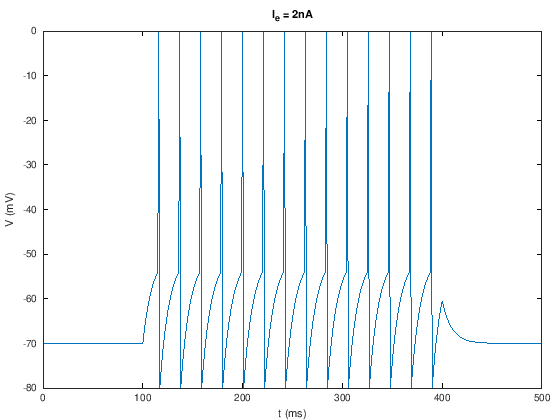

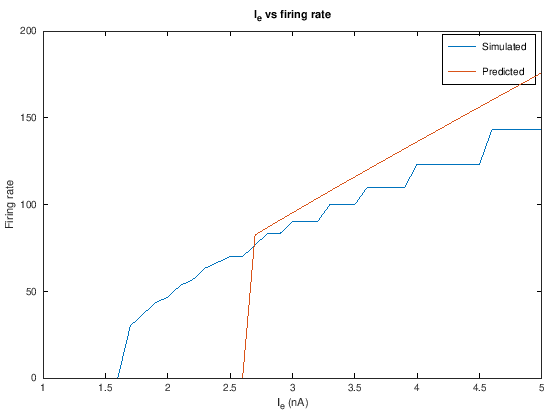

In [27]:
V_rest = -70e-3;
V_th = -54e-3;
V_reset = -80e-3;
V_spike = 0;
R_m = 10e6;
tau_m = 10e-3;
dt = 1e-3;

currents = 1e-9 * (1:0.1:5);
stim = [zeros(1, 100), ones(1, 300), zeros(1, 100)];
spike_counts = [];
for I_e = currents
    V = IFNeuron(V_rest, V_th, V_reset, V_spike, R_m, tau_m, stim * I_e, dt);
    spike_counts = [spike_counts, sum(V==V_spike)];

    if abs(I_e - 2e-9) < 1e-11
        figure()
        plot(0:(size(V, 2) - 1), V * 1e3);
        title(["I_e = ", num2str(I_e * 1e9), "nA"]);
        xlabel('t (ms)');
        ylabel('V (mV)');
    endif
end

r_isi = 1./(tau_m*log((R_m*currents + V_rest - V_reset)./(R_m*currents + V_rest - V_th)));
r_isi = (R_m*currents > V_th - V_reset) .* r_isi;

figure()
plot(currents * 1e9, spike_counts / (dt * sum(stim)));
hold on
plot(currents * 1e9, r_isi);
hold off
title('I_e vs firing rate');
xlabel('I_e (nA)');
ylabel('Firing rate');
legend('Simulated', 'Predicted');

---

## Problem 4

Include an extra current in the integrate-and-fire model to introduce spike-rate adaptation, as described in equations 5.13

$$\tau_m\frac{dV}{dt}=E_L-V-r_mg_\text{sra}(V-E_K)+R_mI_e$$

and 5.14,

$$\tau_\text{sra}\frac{dg_\text{sra}}{dt}=-g_\text{sra}$$

and in the caption to figure 5.6.

### Solution

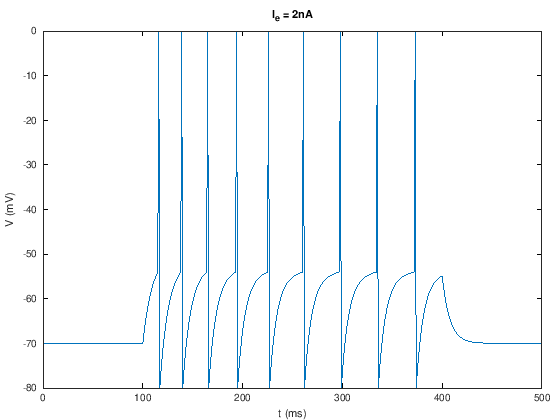

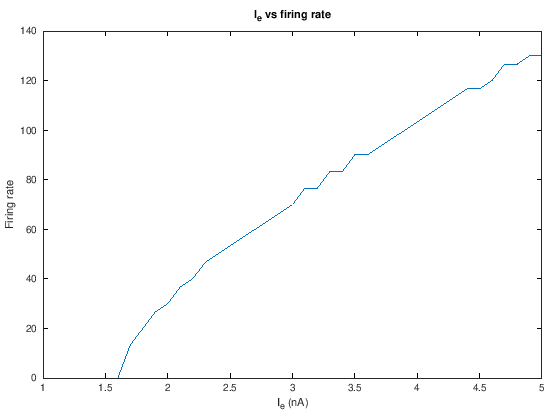

In [28]:
V_rest = -70e-3;
V_th = -54e-3;
V_reset = -80e-3;
V_spike = 0;
R_m = 10e6;
tau_m = 10e-3;
dt = 1e-3;
sra_params = [0.1, 100e-3, -70e-3];

currents = 1e-9 * (1:0.1:5);
stim = [zeros(1, 100), ones(1, 300), zeros(1, 100)];
spike_counts = [];
for I_e = currents
    V = IFNeuron(V_rest, V_th, V_reset, V_spike, R_m, tau_m, stim * I_e, dt, sra_params);
    spike_counts = [spike_counts, sum(V==V_spike)];

    if abs(I_e - 2e-9) < 1e-11
        figure()
        plot(0:(size(V, 2) - 1), V * 1e3);
        title(["I_e = ", num2str(I_e * 1e9), "nA"]);
        xlabel('t (ms)');
        ylabel('V (mV)');
    endif
end

figure()
plot(currents * 1e9, spike_counts / (dt * sum(stim)));
title('I_e vs firing rate');
xlabel('I_e (nA)');
ylabel('Firing rate');

---

## Problem 5

Add an excitatory synaptic conductance to the integrate-and-fire neuron of exercise 3 by adding the extra synaptic conductance term in equation 5.43

$$\tau_m\frac{dV}{dt}=E_L-V-r_m\bar{g}_sP_s(V-E_s)+R_mI_e$$

with $E_s = 0$. Set the external current to zero, $I_e = 0$, in this example, and assume that the probability of release on receipt of a presynaptic spike is 1. Use $r_m\bar{g}_s = 0.5$ and describe $P_s$ using the alpha function of equation 5.35 with $\tau_s = 10$ ms and $P_\text{max} = 0.5$. To incorporate multiple presynaptic spikes, $P_s$ should be described by a pair of differential equations,

$$\tau_s\frac{dP_s}{dt}=eP_\text{max}z-P_s$$

with $e = \exp(1)$, and

$$\tau_s\frac{dz}{dt} = -z$$,

with the additional rule that $z$ is set to 1 whenever a presynaptic spike arrives. Plot $V(t)$ in one graph and the synaptic current in another. Trigger synaptic events at times 50, 150, 190, 300, 320, 400, and 410 ms. Explain what you see.

### Solution

In [1]:
function [V, P_s] = IFSynapseNeuron(V_rest, V_th, V_reset, V_spike, tau_m, dt, g_s, tau_s, V_s, P_max, spikes, is_saturate)
    if ~exist('is_saturate', 'var') || isempty(is_saturate)
      is_saturate = 0;
    end
    
    V = [V_rest];
    P_s = [0];
    z = 0;
    for is_spike = spikes
        if is_spike == 1
            z = 1;
        else
            z = z - dt * z / tau_s;
        end
        P_diff = exp(1) * P_max * z;
        if is_saturate
            P_diff = P_diff * (1 - P_s(end));
        end
        P_s = [P_s, P_s(end) + dt * (P_diff - P_s(end)) / tau_s];
        
        if V(end) == V_spike
            V = [V, V_reset];
            continue;
        end
        
        V_diff = V_rest - V(end) -g_s * P_s(end) * (V(end) - V_s);
        
        V_next = V(end) + dt * V_diff / tau_m;
        if V_next >= V_th
            V_next = V_spike;
        end
        V = [V, V_next];
    end
endfunction

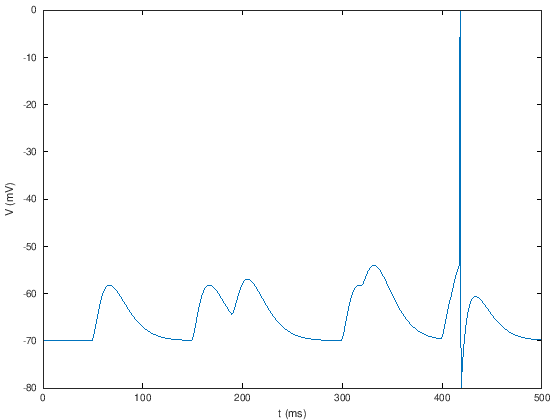

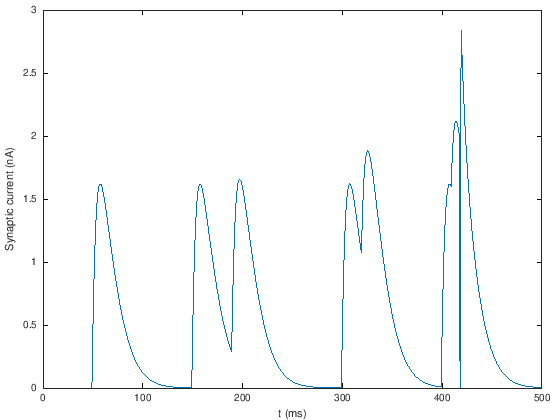

In [57]:
spikes = zeros(1, 500);
spikes(50) = 1;
spikes(150) = 1;
spikes(190) = 1;
spikes(300) = 1;
spikes(320) = 1;
spikes(400) = 1;
spikes(410) = 1;

V_rest = -70e-3;
V_th = -54e-3;
V_reset = -80e-3;
V_spike = 0;
V_s = 0;
R_m = 10e6;
tau_m = 10e-3;
dt = 1e-3;
g_s = 0.5;
tau_s = 10e-3;
P_max = 0.5;

[V, P_s] = IFSynapseNeuron(V_rest, V_th, V_reset, V_spike, tau_m, dt, g_s, tau_s, V_s, P_max, spikes);
timesteps = 0:(size(V, 2) - 1);

figure()
plot(timesteps, V * 1e3);
xlabel('t (ms)');
ylabel('V (mV)');
figure()
plot(timesteps, -1e9 * g_s * P_s .* (V - V_s) / R_m);
xlabel('t (ms)');
ylabel('Synaptic current (nA)');

From the graph above, we see that a single presynaptic event is not enough to cause the neuron to fire. Neither are pairs of presynaptic events separated by 40 or even 20ms. However, when two events occur within 10ms of each other, the neuron's membrane potential crosses the firing threshold and an action potential fires.

At the moment of the spike, the synaptic current drops to 0 as $V(t)=E_s$ at this point, but then resumes as the membrane voltage is reset.

---

## Problem 6

The equations in exercise 5 generate an $\alpha$ function response to a single input spike, but they do not prevent $P_s$ from growing greater than 1 when the model synapse is driven by multiple spikes at a sufficiently high frequency. In other words, this model synapse does not saturate. To introduce saturation, modify the equations of exercise 5 to

$$\tau_s\frac{dP_s}{dt} = e P_\text{max}z(1 − P_s) − P_s$$

with $e = \exp(1)$, and

$$\tau_s\frac{dz}{dt} = -z$$,

with the additional rule that $z$ is set to 1 whenever a presynaptic spike arrives. Compare $P_s(t)$ computed using these equations with $P_s(t)$ computed using the equations of exercise 5 for constant rate, regular (periodic) presynaptic spike trains with frequencies ranging from 1 to 100 Hz. In both cases, use $\tau_s = 10$ ms and $P_\text{max} = 0.5$.

### Solution

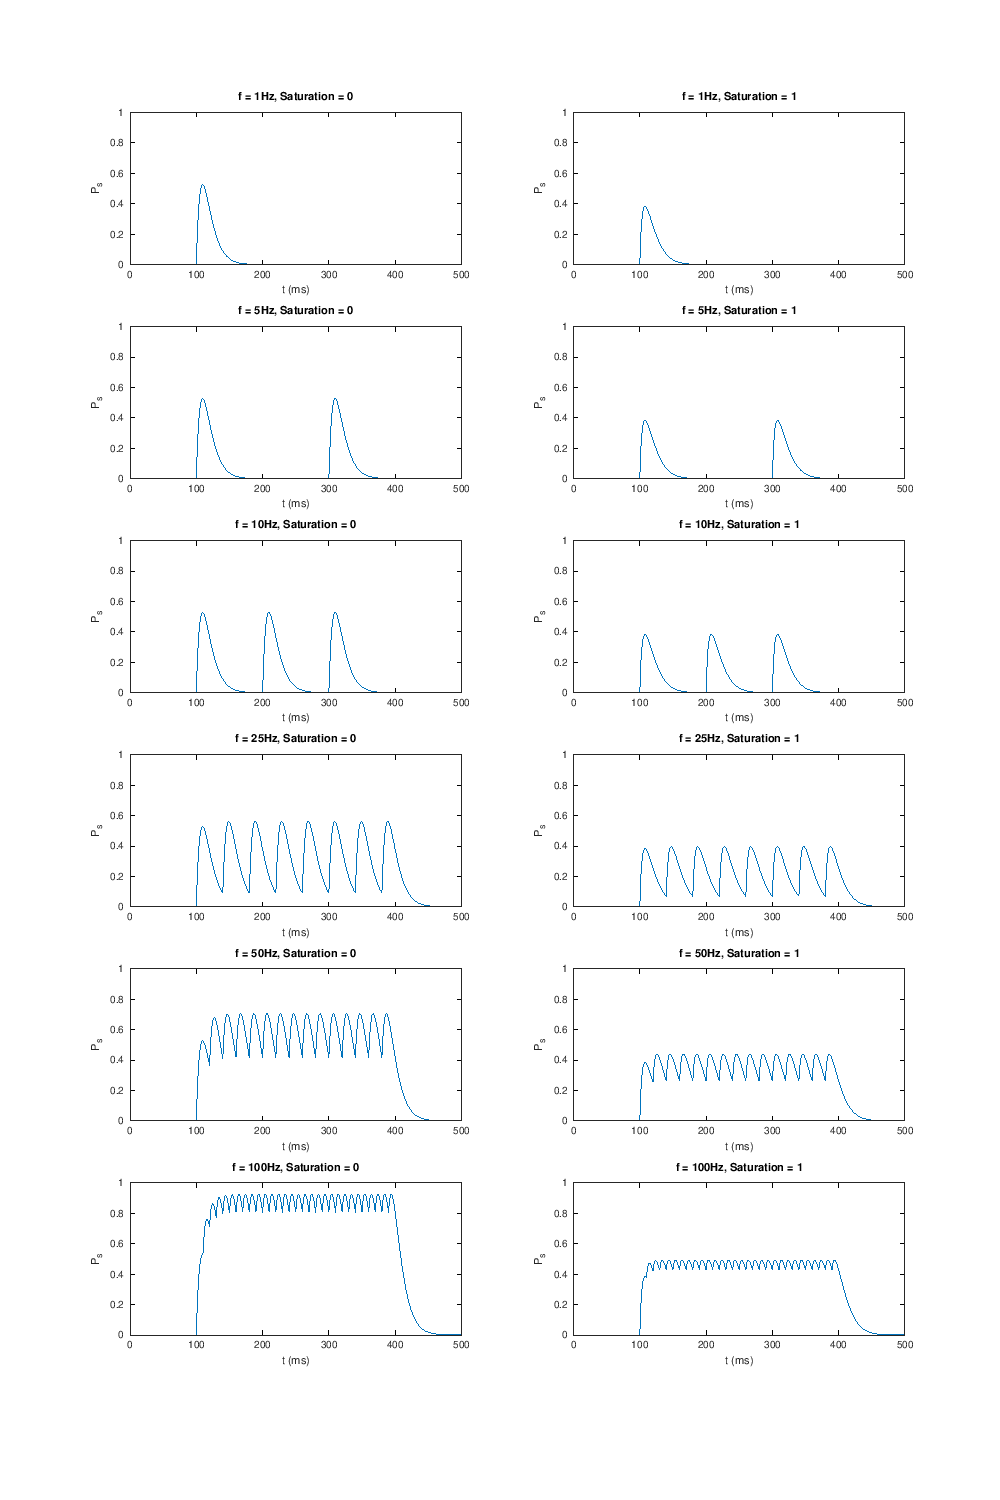

In [26]:
V_rest = -70e-3;
V_th = -54e-3;
V_reset = -80e-3;
V_spike = 0;
V_s = 0;
R_m = 10e6;
tau_m = 10e-3;
dt = 1e-3;
g_s = 0.5;
tau_s = 10e-3;
P_max = 0.5;

steps = 500;
stim_steps = 300;
frequencies = [1, 5, 10, 25, 50, 100];
figure('position', [0, 0, 1000, 250 * length(frequencies)])
for i = 1:length(frequencies)
    f = frequencies(i);
    block_size = 1 / (dt * f);
    spikes = [];
    while length(spikes) < stim_steps
        block = zeros(1, block_size);
        block(1) = 1;
        spikes = [spikes block];
    end
    buffer = 0.5 * (steps - stim_steps);
    spikes = [zeros(1, buffer) spikes(1:stim_steps) zeros(1, buffer)];
    t = 0:size(spikes, 2);
    
    for is_sat = [0 1]
        [V, P_s] = IFSynapseNeuron(V_rest, V_th, V_reset, V_spike, tau_m, dt, g_s, tau_s, V_s, P_max, spikes, is_sat);
        subplot(length(frequencies), 2, 2*i - 1 + is_sat);
        plot(t, P_s);
        title(["f = ", num2str(f), "Hz, Saturation = ", num2str(is_sat)]);
        xlabel("t (ms)");
        ylabel("P_s");
        axis([-inf inf 0 1]);
    end
end

---

## Problem 7

Construct a model of two coupled integrate-and-fire neurons similar to that of figure 5.20. Both model neurons obey equation 5.43

$$\tau_m\frac{dV}{dt}=E_L-V-r_m\bar{g}_sP_s(V-E_s)+R_mI_e$$

with $E_L = -70$ mV, $V_\text{th} = -54$ mV, $V_\text{reset} = -80$ mV, $\tau_m = 20$ ms, $r_m \bar{g}_s = 0.15$, and $R_mI_e = 18$ mV. Both synapses should be described as in exercise 5 with $P_\text{max} = 0.5$ and $\tau_s = 10$ ms. Consider cases where both synapses are excitatory, with $E_s = 0$ mV, and both are inhibitory, with $E_s = -80$ mV. Show how the pattern of firing for the two neurons depends on the type (excitatory or inhibitory) of the reciprocal synaptic connections. For these simulations, set the initial membrane voltages of the two neurons to slightly different values, randomly, and run the simulation until an equilibrium situation has been reached, which may take a few seconds of simulated run time. Start from a few different random initial conditions to study whether the results are consistent. Investigate what happens if you change the strengths and time constants of the reciprocal synapses.

### Solution

In [25]:
function [V, P_s, z] = EvolveIFSynapseNeuron(neuron, V, P_s, z, is_spike)
    [V_rest, V_th, V_reset, V_spike, tau_m, V_e, g_s, tau_s, V_s, P_max, dt] = deal(neuron{:});
    
    if is_spike == 1
        z = 1;
    else
        z = z - dt * z / tau_s;
    end
    P_s = P_s + dt * (exp(1) * P_max * z - P_s) / tau_s;
    
    if V(end) == V_spike
        V = [V, V_reset];
        return;
    end

    V_diff = V_rest - V(end) - g_s * P_s * (V(end) - V_s) + V_e;
    V_next = V(end) + dt * V_diff / tau_m;
    if V_next >= V_th
        V_next = V_spike;
    end
    
    V = [V, V_next];
endfunction

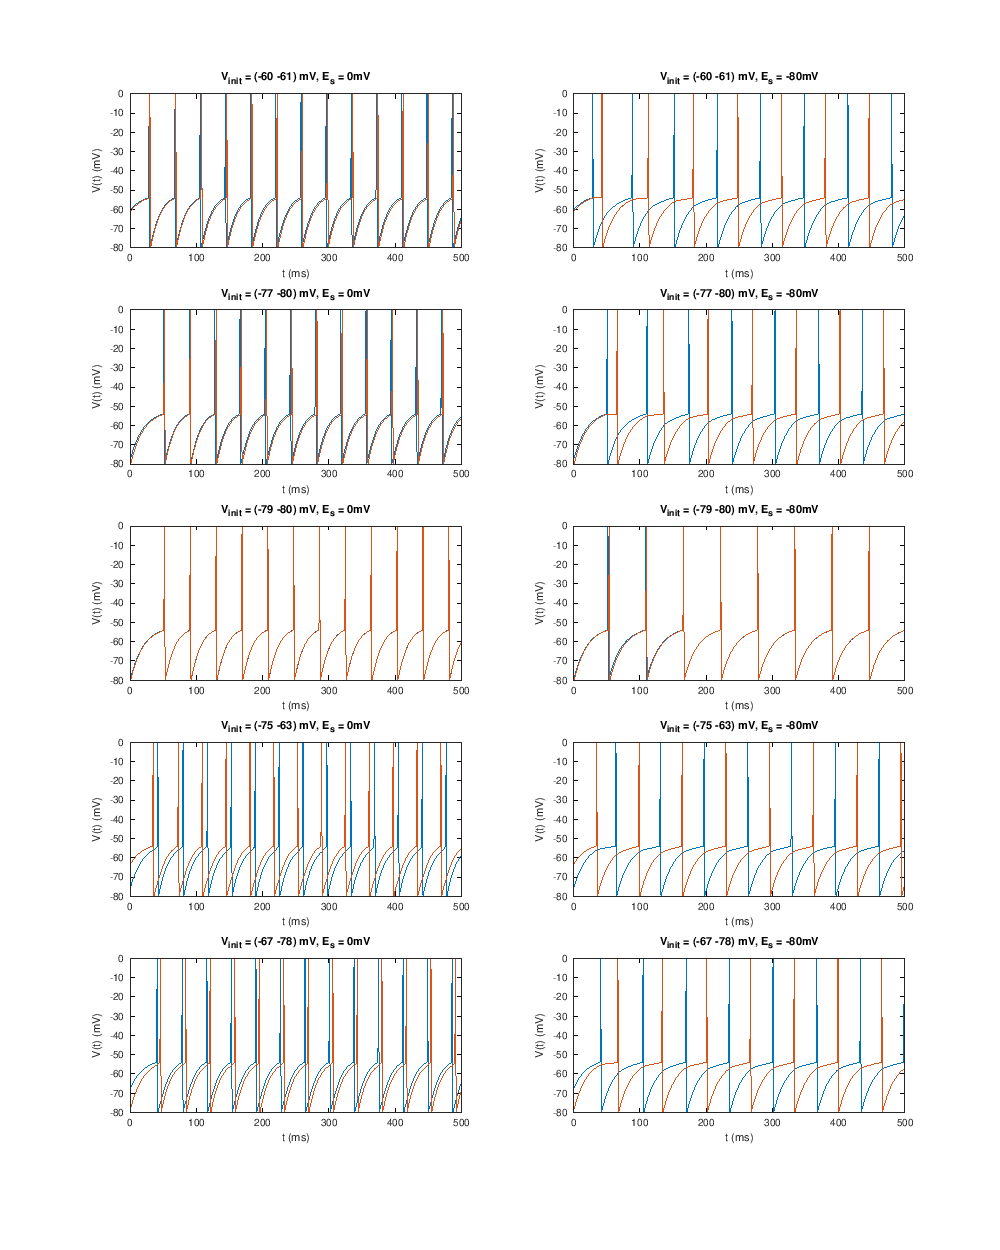

In [45]:
V_rest = -70e-3;
V_th = -54e-3;
V_reset = -80e-3;
V_spike = 0;
tau_m = 20e-3;
V_e = 18e-3;
g_s = 0.15;
tau_s = 10e-3;
P_max = 0.5;
dt = 1e-3;

num_restarts = 5;
V_init = 1e-3 * randi([-80, -60], [num_restarts, 2]);
V_synapse = [0, -80e-3];
figure('position', [0, 0, 1000, 250 * num_restarts])
for i = 1:num_restarts
    for j = 1:2
        V_s = V_synapse(j);
        V_1 = [V_init(i, 1)];
        P_s_1 = 0;
        z_1 = 0;
        V_2 = [V_init(i, 2)];
        P_s_2 = 0;
        z_2 = 0;
        neuron = num2cell([V_rest, V_th, V_reset, V_spike, tau_m, V_e, g_s, tau_s, V_s, P_max, dt]);
        for k = 1:499
            [V_1, P_s_1, z_1] = EvolveIFSynapseNeuron(neuron, V_1, P_s_1, z_1, V_2(end) == V_spike);
            [V_2, P_s_2, z_2] = EvolveIFSynapseNeuron(neuron, V_2, P_s_2, z_2, V_1(end) == V_spike);
        end
        subplot(num_restarts, 2, 2*(i - 1) + j);
        plot(1:size(V_1, 2), V_1 * 1e3);
        hold on
        plot(1:size(V_2, 2), V_2 * 1e3);
        hold off
        title(["V_{init} = (", num2str(1e3 * V_init(i, :)), ") mV, E_s = ", num2str(1e3 * V_s), "mV"]);
        xlabel('t (ms)');
        ylabel('V(t) (mV)');
    end
end

---

## Problem 8

Build a Hodgkin-Huxley model neuron by numerically integrating the equations for $V$, $m$, $h$, and $n$ given in chapter 5 (see, in particular equations 5.6,

$$c_m\frac{dV}{dt}=-i_m+\frac{I_e}{A}$$

5.17–5.19,

$$\tau_n(V)\frac{dn}{dt}=n_\infty(V)-n$$
$$\tau_n(V)=\frac{1}{\alpha_n(V)+\beta_n(V)}$$
$$n_\infty(V)=\frac{\alpha_n(V)}{\alpha_n(V)+\beta_n(V)}$$

5.22,
$$\alpha_n=\frac{0.01(V+55)}{1-\exp(-0.1(V+55))}\,\text{ and }\,\beta_n=0.125\exp(-0.0125(V+65))$$

5.24,
$$\alpha_m=\frac{0.1(V+40)}{1-\exp(-0.1(V+40))}\,\text{ }\,\beta_m=4\exp(-0.0556(V+65))$$
$$\alpha_h=0.07\exp(-0.05(V+65))\,\text{ }\,\beta_h=1/(1+\exp(-0.1(V+35)))$$

and 5.25).
$$i_m=\bar{g}_L(V-E_L)+\bar{g}_Kn^4(V-E_K)+\bar{g}_\text{Na}m^3h(V-E_\text{Na})$$


Take $c_m = 10$ nF/mm$^2$ , and as initial values take: $V = -65$ mV, $m = 0.0529$, $h = 0.5961$, and $n = 0.3177$. Use an integration time step of 0.1 ms.

### Part A
Use an external current with $I_e/A = 200$ nA/mm$^2$ and plot $V$, $m$, $h$, and $n$ as functions of time for a suitable interval.

### Solution

In [13]:
function out = gate_new(gate, alpha, beta, dt)
    out = max(0, min(1, gate + dt * 1e3 * (alpha*(1-gate) - beta*gate)));
endfunction

function [Vs, n, m, h, i_m, spikes] = HogkinHuxleyNeuron(neuron, currents)
    [c_m,E_L,g_L,E_K,g_K,E_Na,g_Na,dt] = deal(neuron{:});
    
    n = [0.3177];
    m = [0.0529];
    h = [0.5961];
    Vs = [-65e-3];
    i_m = [0];
    spikes = 0;
    is_spiking = 0;

    for I_e_A = currents
        V = Vs(end);
        
        mV = V * 1e3;
        if is_spiking == 0 && V > 0
            is_spiking = 1;
            spikes = spikes + 1;
        elseif is_spiking == 1 && V < 0
            is_spiking = 0;
        end

        alpha_n = (0.01 * (mV + 55)) / (1 - exp(-0.1 * (mV + 55)));
        beta_n = 0.125 * exp(-0.0125 * (mV + 65));
        n = [n, gate_new(n(end), alpha_n, beta_n, dt)];

        alpha_m = (0.1 * (mV + 40))/(1 - exp(-0.1 * (mV + 40)));
        beta_m = 4 * exp(-0.0556 * (mV + 65));
        m = [m, gate_new(m(end), alpha_m, beta_m, dt)];

        alpha_h = 0.07 * exp(-0.05 * (mV + 65));
        beta_h = 1 / (1 + exp(-0.1 * (mV + 35)));
        h = [h, gate_new(h(end), alpha_h, beta_h, dt)];

        i_m = [i_m, g_L*(V - E_L) + g_K*n(end)^4*(V - E_K) + g_Na*m(end)^3*h(end)*(V - E_Na)];
        Vs = [Vs, V + dt * (-i_m(end) + I_e_A) / c_m];
    end
endfunction

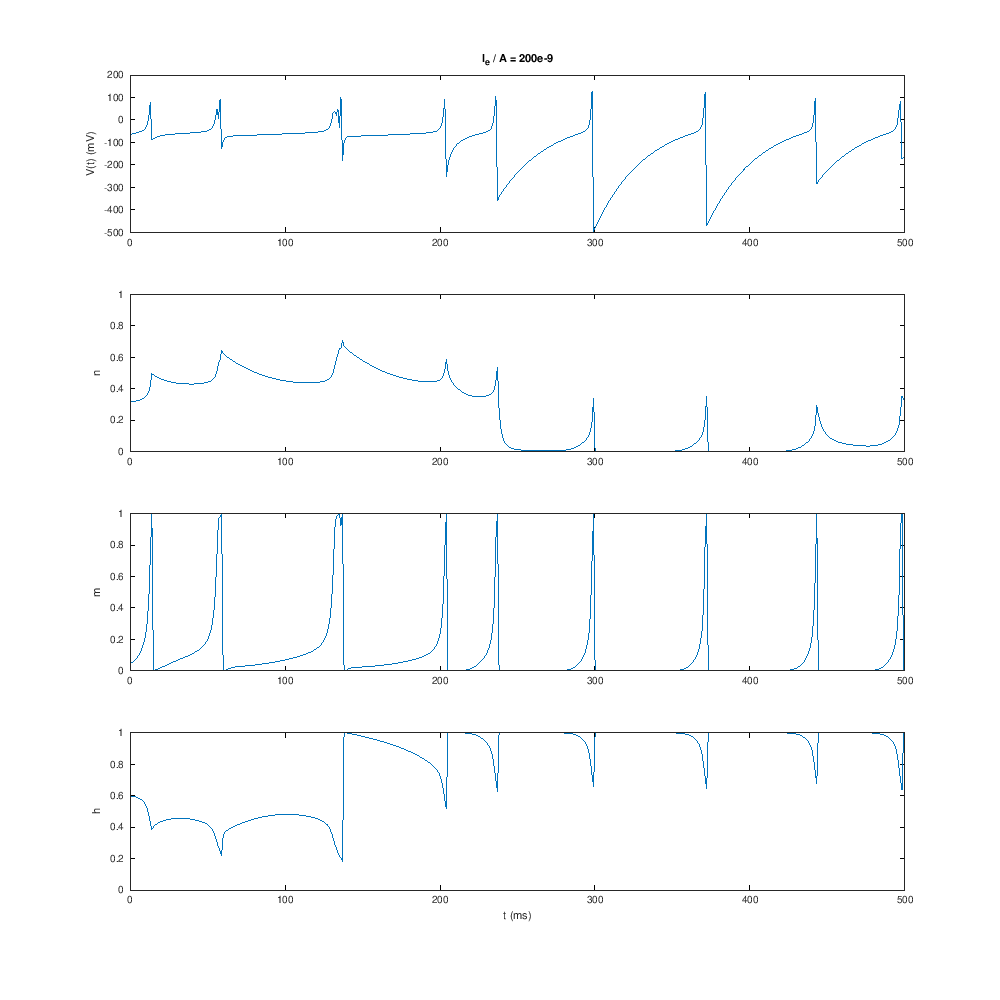

In [22]:
c_m = 10e-9;
E_L = -54.387e-3;
g_L = 0.003e-3;
E_K = -77e-3;
g_K = 0.36e-3;
E_Na = 50e-3;
g_Na = 1.2e-3;
dt = 0.1e-3;
timesteps = 500;

neuron = num2cell([c_m,E_L,g_L,E_K,g_K,E_Na,g_Na,dt]);
[Vs, n, m, h, i_m, spikes] = HogkinHuxleyNeuron(neuron, 200e-9 * ones(1, timesteps - 1));
figure('position', [0 0 1000 1000]);
subplot(4, 1, 1);
t = 0.1 * 1:size(Vs, 2);
plot(t, Vs * 1e3);
title(['I_e / A = ', num2str(I_e_A * 1e9), 'e-9']);
ylabel('V(t) (mV)');

subplot(4, 1, 2);
plot(t, n);
axis([-inf inf 0 1]);
ylabel('n');

subplot(4, 1, 3);
plot(t, m);
axis([-inf inf 0 1]);
ylabel('m');

subplot(4, 1, 4);
plot(t, h);
axis([-inf inf 0 1]);
ylabel('h');
xlabel('t (ms)');

### Part B

Also, plot the firing rate of the model as a function of $I_e/A$ over the range from 0 to 500 nA/mm$^2$ . Show that the firing rate jumps discontinuously from zero to a finite value when the current passes through the minimum value required to produce sustained firing.

### Solution

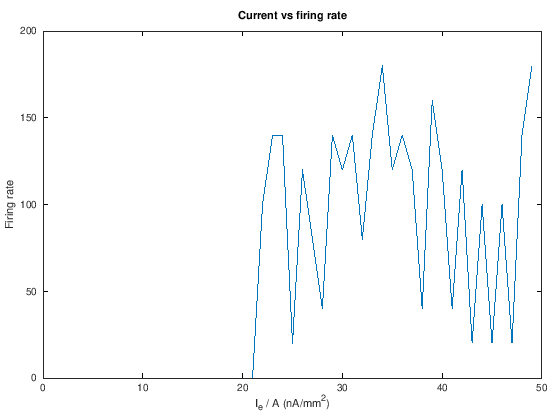

In [30]:
currents = 1e-9 * (1:49);
spikes = [];

for I_e_A = currents
    [Vs, n, m, h, i_m, spike] = HogkinHuxleyNeuron(neuron, I_e_A * ones(1, timesteps - 1));
    spikes = [spikes, spike];
end

plot(currents * 1e9, spikes / (dt * timesteps));
title('Current vs firing rate');
xlabel('I_e / A (nA/mm^2)');
ylabel('Firing rate');

### Part C
Finally, apply a pulse of negative current with $I_e/A = -50$ nA/mm$^2$ for 5 ms followed by $I_e/A = 0$ and show what happens.

### Solution

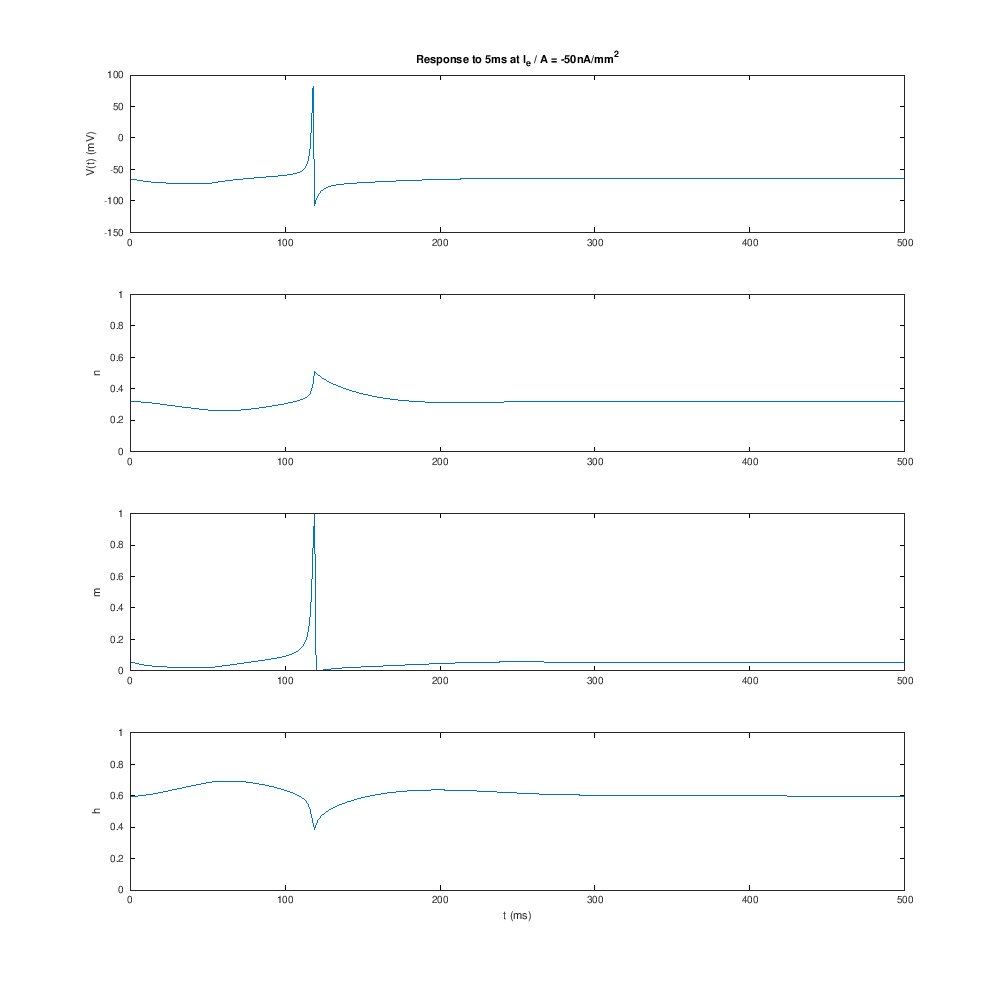

In [24]:
currents = zeros(1, 499);
currents(1:(5e-3 / dt)) = -50e-9;
[Vs, n, m, h, i_m, spikes] = HogkinHuxleyNeuron(neuron, currents);

figure('position', [0 0 1000 1000]);
subplot(4, 1, 1);
t = 0.1 * 1:size(Vs, 2);
plot(t, Vs * 1e3);
title('Response to 5ms at I_e / A = -50nA/mm^2');
ylabel('V(t) (mV)');

subplot(4, 1, 2);
plot(t, n);
axis([-inf inf 0 1]);
ylabel('n');

subplot(4, 1, 3);
plot(t, m);
axis([-inf inf 0 1]);
ylabel('m');

subplot(4, 1, 4);
plot(t, h);
axis([-inf inf 0 1]);
ylabel('h');
xlabel('t (ms)');

---

## Problem 9

Construct and simulate the K$^+$ channel model of figure 5.12. Plot the mean squared deviation between the current produced by $N$ such model channels and the Hodgkin-Huxley current as a function of $N$ over the range $1 \le N \le 100$, matching the amplitude of the Hodgkin-Huxley model so that the mean currents are the same.

### Solution

In [28]:
pkg load statistics

dt = 0.1;
Vs = repelems([-100, 10], [[1 2 1]; [100 200 200]]);
Ns = [1 10 100];
gates = [];

E_K = -77e-3;
g_K = 0.36e-3;
n = 0.3177;
HH = [];

for N = Ns
    p = [N; zeros(4, 1)];
    open_gates = [];
    for mV = Vs
        alpha = (0.01 * (mV + 55)) / (1 - exp(-0.1 * (mV + 55)));
        beta = 0.125 * exp(-0.0125 * (mV + 65));
        if length(HH) < length(Vs)
            n = min(max(n + dt * (alpha*(1-n) - beta*n), 0), 1);
            HH = [HH, g_K*n^4*(mV*1e-3 - E_K)];
        end
        
        dP = [ ...
            [-4*alpha, beta,              0,                   0,                 0]; ...
            [4*alpha,  -(beta + 3*alpha), 2*beta,              0,                 0]; ...
            [0,        3*alpha,           -(2*beta + 2*alpha), 3*beta,            0]; ...
            [0,        0,                 2*alpha,             -(3*beta + alpha), 4*beta]; ...
            [0,        0,                 0,                   alpha,             -4*beta]; ...
        ];
        T = dt * dP .* ~eye(size(dP));
        T = T + diag(1 - sum(T, 1));
        
        p_new = [];
        for i = find(p)'
            [C, ia, ic] = unique([randsample(5, p(i), true, T(:, i)), 1:5]);
            p_new = [p_new accumarray(ic', 1) - 1];
        end
        p = sum(p_new, 2);
        open_gates = [open_gates, p(5)];
    end
    gates = [gates; open_gates];
end

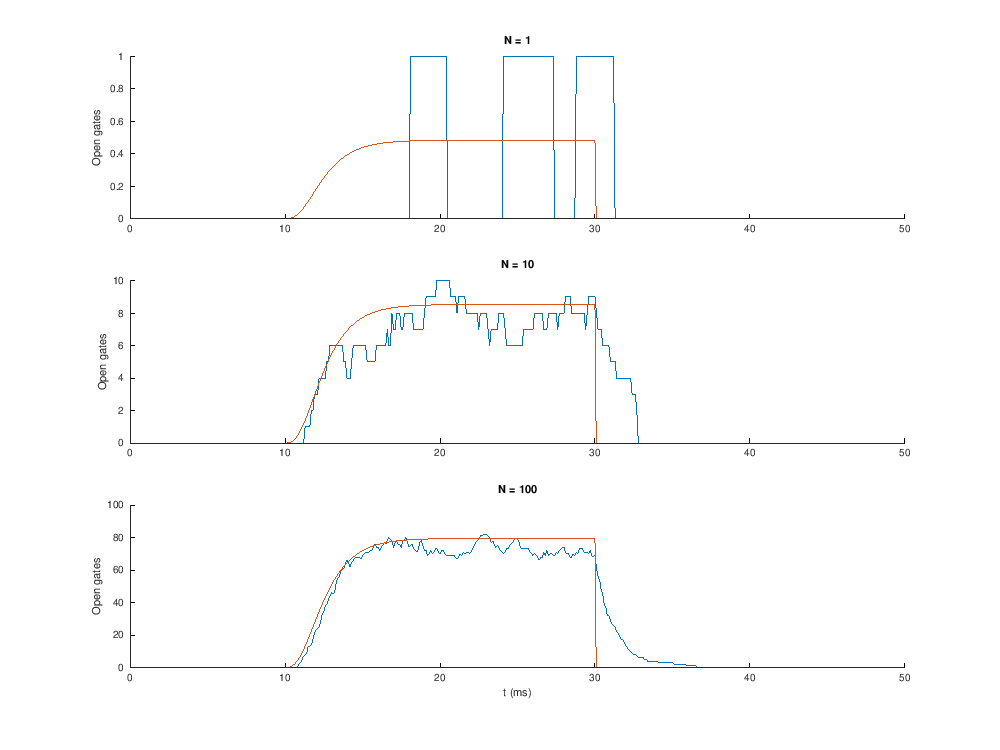

In [55]:
t = dt * (1:length(Vs));
figure('position', [0 0 1000 750]);
e_current = [];

for i = 1:length(Ns)
    open_gates = gates(i, :);
    N = Ns(i);
    HH_N = HH * sum(open_gates) / sum(HH);
    e_current = [e_current, sqrt(sum(((open_gates - HH_N) / N).^2) / length(open_gates))];
    
    subplot(3, 1, i);
    plot(t, open_gates);
    hold on
    plot(t, HH_N);
    hold off
    set(gca, 'box', 'off');
    title(['N = ', num2str(N)]);
    ylabel('Open gates');
    axis([-inf inf 0 Ns(i)]);
end
xlabel('t (ms)');

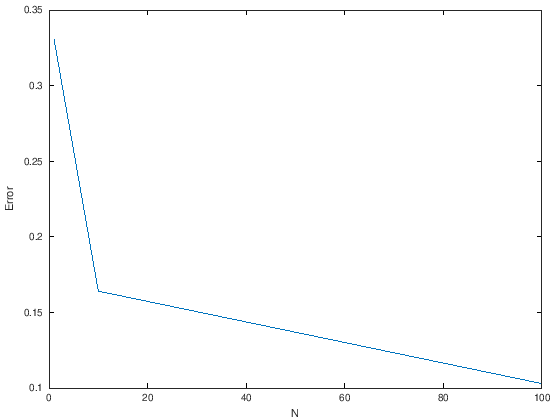

In [60]:
plot(Ns, e_current);
ylabel('Error');
xlabel('N');

---

## Problem 10

Compute analytically the value of the release probability $P_\text{rel}$ just before the time of each presynaptic spike for a regular (periodic rather than Poisson), constant-frequency presynaptic spike train as a function of the presynaptic firing rate. Do this for both the depression and facilitation models described by equation 5.37.

$$\tau_P\frac{dP_\text{rel}}{dt}=P_0-P_\text{rel}$$

### Solution

TODO